In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import cv2
import os

In [2]:
input_dir = '/kaggle/input/deepfashion-1/datasets'
images_dir = os.path.join(input_dir, 'train_images')
masks_dir = os.path.join(input_dir, 'segm')

for dirname, _, filenames in os.walk(images_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Sweaters-id_00005253-06_1_front.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Blouses_Shirts-id_00004602-01_4_full.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Blouses_Shirts-id_00007196-04_4_full.png
/kaggle/input/deepfashion-1/datasets/train_images/MEN-Tees_Tanks-id_00004170-05_4_full.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Tees_Tanks-id_00003917-73_4_full.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Tees_Tanks-id_00005292-05_7_additional.png
/kaggle/input/deepfashion-1/datasets/train_images/MEN-Jackets_Vests-id_00000094-02_7_additional.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Dresses-id_00002507-01_7_additional.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Dresses-id_00001475-03_7_additional.png
/kaggle/input/deepfashion-1/datasets/train_images/WOMEN-Shorts-id_00003578-02_4_full.png
/kaggle/input/deepfashion-1/datasets/train_images/

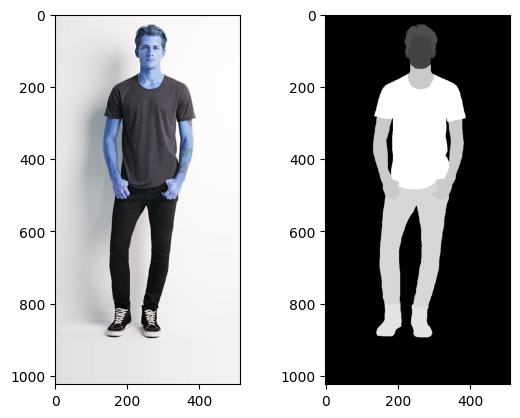

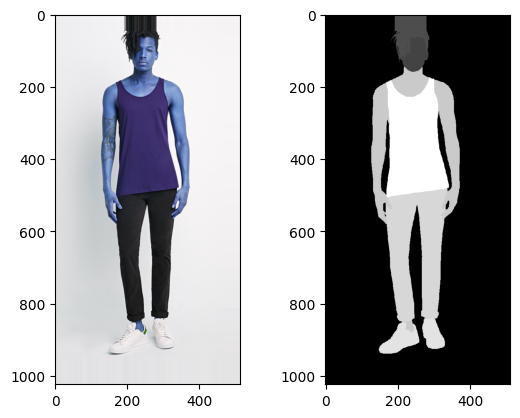

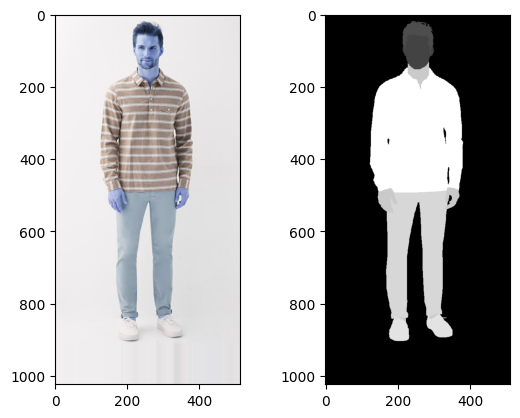

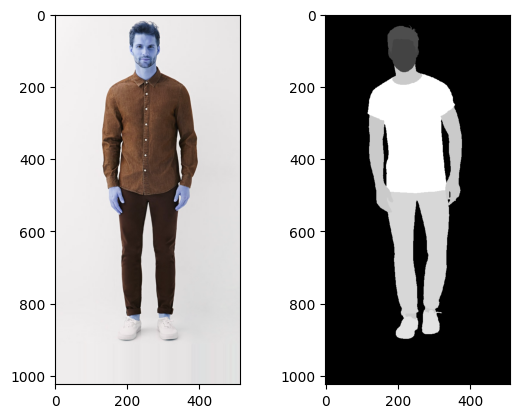

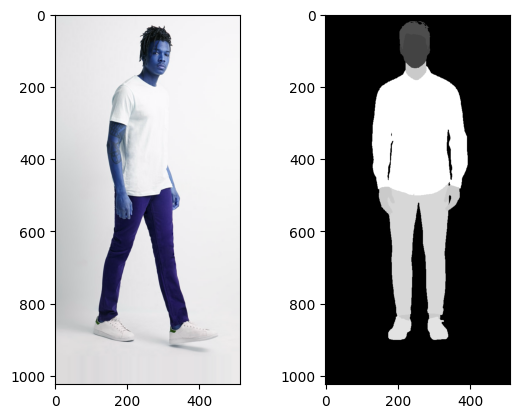

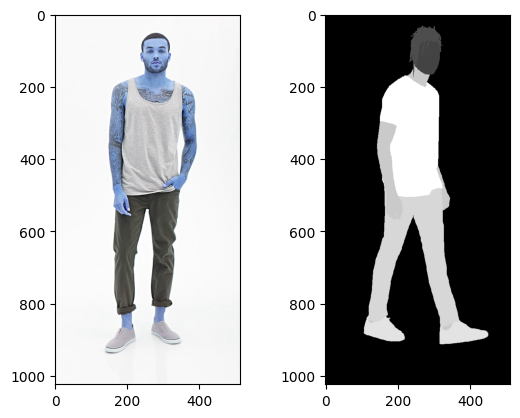

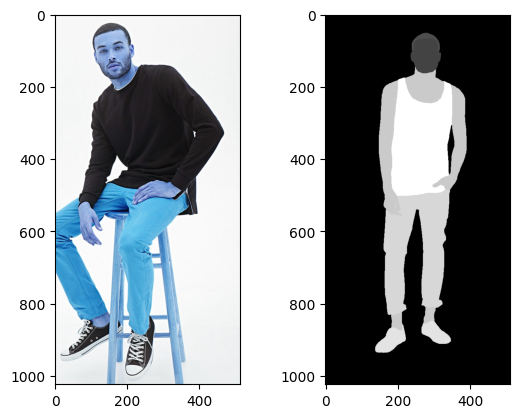

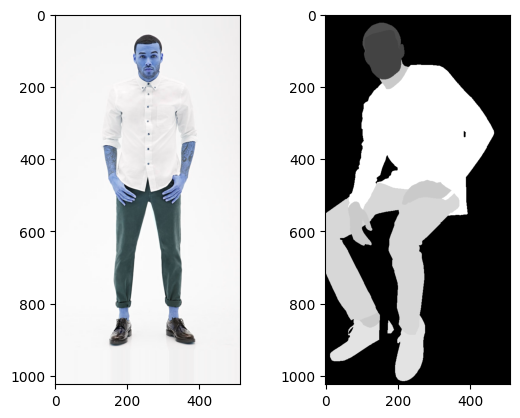

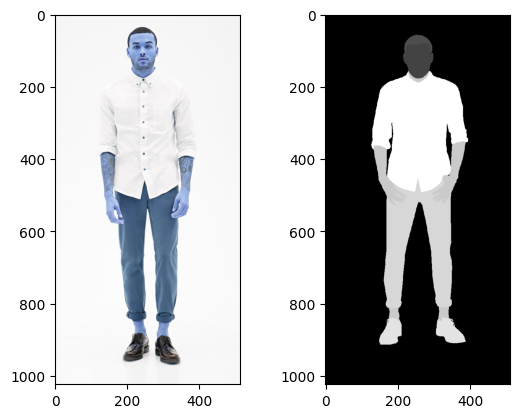

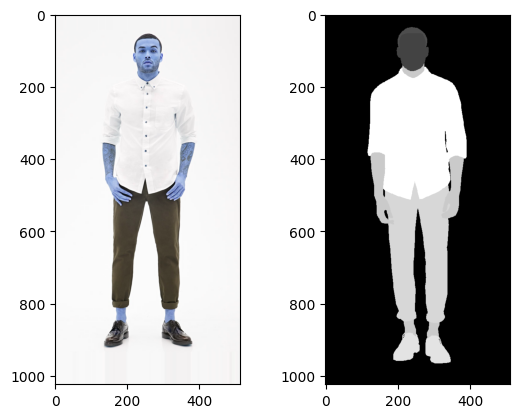

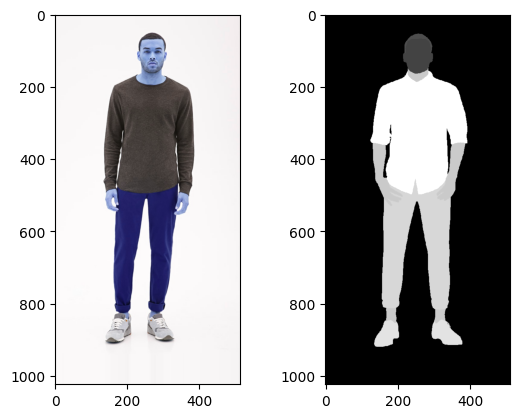

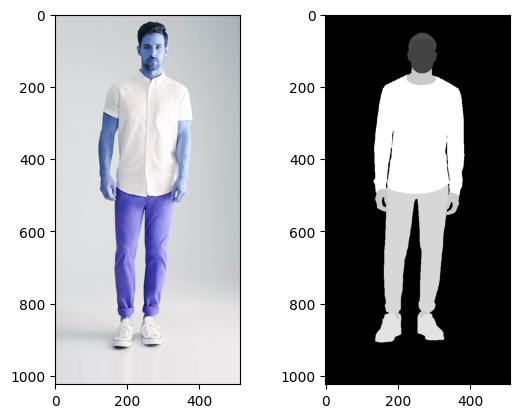

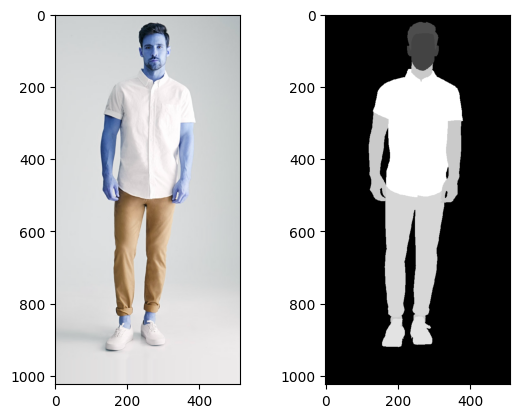

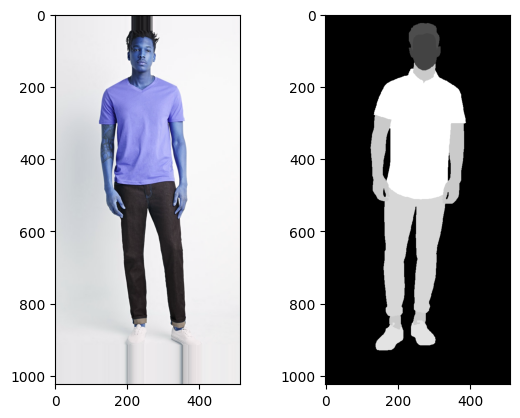

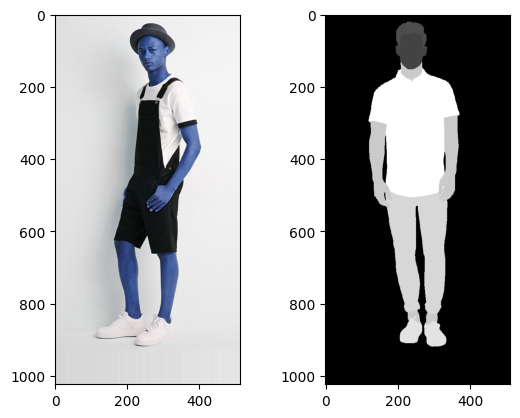

In [3]:
import matplotlib.pyplot as plt

# Fonction pour charger les images et masques en petits lots
def load_images_in_batches(images_dir, masks_dir, batch_size=32):
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    
    for i in range(0, len(image_files), batch_size):
        batch_images = [cv2.imread(os.path.join(images_dir, img)) for img in image_files[i:i+batch_size]]
        batch_masks = [cv2.imread(os.path.join(masks_dir, mask), 0) for mask in mask_files[i:i+batch_size]]
        
        return batch_images , batch_masks

# Appel de la fonction pour charger les images et masques en petits lots
batch_images, batch_masks = load_images_in_batches(images_dir, masks_dir, batch_size=32)


def display_samples(images, masks, num=15):
    for i in range(num):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[i])
        ax[1].imshow(masks[i], cmap='gray')
        plt.show()

display_samples(batch_images, batch_masks)

In [4]:

# Convertir en tableaux numpy
train_images = np.array(batch_images)
train_masks = np.array(batch_masks)

In [5]:

# Diviser les données : 80 % pour l'entraînement, 20 % pour la validation
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [6]:

# Redimensionner les images et masques
IMG_HEIGHT, IMG_WIDTH = 256, 256
train_images = np.array([cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in train_images])
train_masks = np.array([cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) for mask in train_masks])
val_images = np.array([cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in val_images])
val_masks = np.array([cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) for mask in val_masks])

In [7]:
# Normalisation des pixels
train_images = train_images / 255.0
val_images = val_images / 255.0
train_masks = train_masks / 255.0
val_masks = val_masks / 255.0

In [8]:

# Reshape des masques
train_masks = np.expand_dims(train_masks, axis=-1)
val_masks = np.expand_dims(val_masks, axis=-1)

In [9]:

# Modèle U-Net
def unet_model(input_size=(256, 256, 3)):
    
    ## ------ Chemin Contractant -------- ##
    inputs = layers.Input(input_size)
    # Bloc1
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Bloc2
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bloc 3
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bloc 4
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bloc 5
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    ## -- Chemin Expansif ----- #
    # Bloc 6
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    # Bloc 7
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    # Bloc 8
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    # Bloc 9
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model

In [10]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:

# Entraînement du modèle
model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10
          , batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 94s 94s/step - accuracy: 0.0130 - loss: 0.7078 - val_accuracy: 0.7341 - val_loss: 0.6060
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.7453 - loss: 0.6018 - val_accuracy: 0.7341 - val_loss: 0.5297
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.7453 - loss: 0.4873 - val_accuracy: 0.7341 - val_loss: 0.5012
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.7453 - loss: 0.4758 - val_accuracy: 0.7341 - val_loss: 0.5081
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.7453 - loss: 0.4713 - val_accuracy: 0.7341 - val_loss: 0.5085
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.7453 - loss: 0.4706 - val_accuracy: 0.7341 - val_loss: 0.4972
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.7453 - loss: 0.4663 - val_accuracy: 0.7341 - val_loss: 0.4941
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - accuracy: 0.7453 - loss: 0.4660 - val_accuracy: 0.7341 - val_loss: 0

In [12]:
image_path = '/kaggle/input/data-th/WhatsApp Image 2024-10-16 at 11.29.33.jpeg'

Forme de l'image d'entrée : (1, 256, 256, 3)


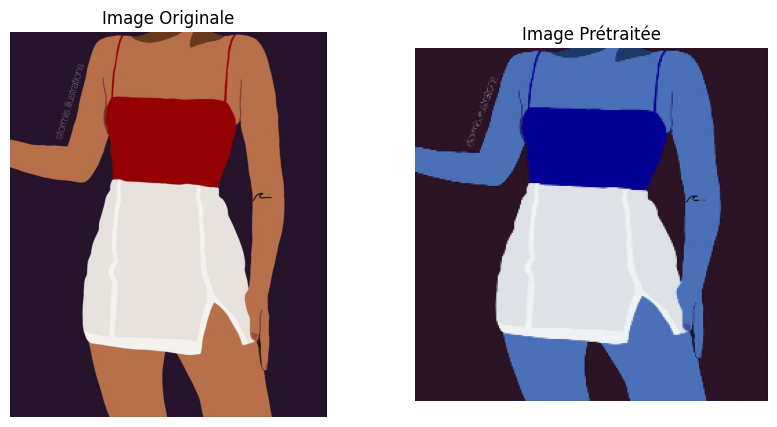

In [13]:
# 1. Charger l'Image
image = cv2.imread(image_path)

# 2. Redimensionner l'Image
image_resized = cv2.resize(image, (256, 256))

# 3. Normaliser les Pixels
image_normalized = image_resized / 255.0

# 4. Reshape l'Image
image_input = np.expand_dims(image_normalized, axis=0)  # Ajout d'une dimension pour faire (1, 256, 256, 3)

# Vérification de la forme de l'image après prétraitement
print("Forme de l'image d'entrée :", image_input.shape)

# Afficher l'image originale et l'image prétraitée
plt.figure(figsize=(10, 5))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

# Image prétraitée
plt.subplot(1, 2, 2)
plt.imshow(image_normalized)
plt.title('Image Prétraitée')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


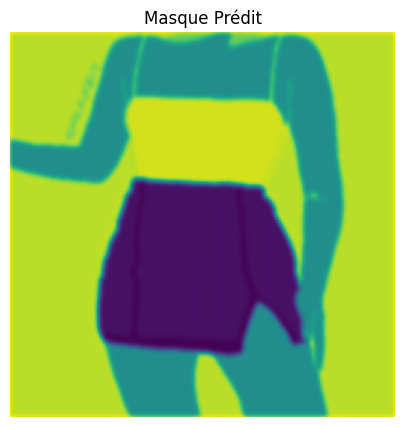

In [14]:
# Prédire le masque avec le modèle U-Net
predicted_mask = model.predict(image_input)

# Afficher le masque prédit
plt.figure(figsize=(5, 5))
plt.imshow(predicted_mask[0, :, :, 0])  # Afficher le masque prédit
plt.title('Masque Prédit')
plt.axis('off')
plt.show()

In [15]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
Note: you may need to restart the kernel to use updated packages.


In [16]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Pré-traitement de l'image : redimensionnement et normalisation
def preprocess_image(image):
    try:
        image_resized = cv2.resize(image, (256, 256))
        image_normalized = image_resized / 255.0  # Normaliser entre 0 et 1
        image_input = np.expand_dims(image_normalized, axis=0)  # Ajouter la dimension batch
        return image_input
    except Exception as e:
        print(f"Erreur dans le pré-traitement de l'image : {str(e)}")
        return None

# Post-traitement du masque pour affichage
def postprocess_mask(mask, original_image_shape):
    try:
        mask_resized = cv2.resize(mask, (original_image_shape[1], original_image_shape[0]))  # Redimensionner
        return mask_resized
    except Exception as e:
        print(f"Erreur dans le post-traitement du masque : {str(e)}")
        return None

# Fonction de prédiction
def predict_mask(image):
    try:
        # Prétraiter l'image
        image_input = preprocess_image(image)
        if image_input is None:
            return "Erreur lors du prétraitement de l'image", None
        
        # Faire la prédiction
        predicted_mask = model.predict(image_input)[0]  # Prédiction, on retire le batch
        if predicted_mask is None:
            return "Erreur lors de la prédiction", None
        
        # Post-traitement du masque pour affichage
        predicted_mask_resized = postprocess_mask(predicted_mask, image.shape)
        if predicted_mask_resized is None:
            return "Erreur lors du post-traitement du masque", None
        
        # Retourner l'image d'origine et le masque prédit
        return image, predicted_mask_resized
    except Exception as e:
        print(f"Erreur dans la fonction de prédiction : {str(e)}")
        return f"Erreur : {str(e)}", None

# Interface Gradio
interface = gr.Interface(
    fn=predict_mask,
    inputs=gr.Image(type="numpy"),  # L'image sera chargée sous forme de tableau numpy
    outputs=[gr.Image(type="numpy", label="Image Originale"), 
             gr.Image(type="numpy", label="Masque Prédit")],
    title="U-Net Segmentation de Vêtements",
    description="Téléchargez une image et le modèle U-Net prédira le masque de segmentation."
)

# Lancer l'interface
interface.launch(share=True)  # Utilisez share=True si vous êtes dans un environnement distant (Kaggle, Colab)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b743cc7a7917ffa977.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
